In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from transformers import PreTrainedModel, LlamaConfig, LlamaModel, LlamaTokenizer
import torch.nn as nn
import torch
from typing import Optional, List
import pandas as pd
import ast
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# for i in range(torch.cuda.device_count()):
#    print(torch.cuda.get_device_properties(i).name)
# cuda = torch.device('cuda')
# b1 = torch.tensor([1., 2.]).to(device=cuda)

In [2]:
from transformers import PreTrainedModel, LlamaConfig, LlamaModel, LlamaTokenizer
import torch.nn as nn
import torch
from typing import Optional, List

class LlamaRewardModel(PreTrainedModel):
    config_class = LlamaConfig
    def __init__(self, config):
        super().__init__(config)
        self.model = LlamaModel(config)
        self.regression_head = nn.Linear(self.config.hidden_size, 1, bias=False)

    def forward( # args are the same as LlamaForCausalLM
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):

        transformer_outputs = self.model(
                                input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                past_key_values=past_key_values,
                                inputs_embeds=inputs_embeds,                               
                            )

        hidden_states = transformer_outputs[0]
        rewards = self.regression_head(hidden_states).squeeze(-1)
        
        ends = attention_mask.cumsum(dim=1).argmax(dim=1).view(-1,1)
        rewards = torch.gather(rewards, 1, ends)
        
        return rewards

tokenizer = LlamaTokenizer.from_pretrained("openbmb/UltraRM-13b", cache_dir='/scratch/henrypapadatos')

#load the model in 16-bit precision
model = LlamaRewardModel.from_pretrained("openbmb/UltraRM-13b", cache_dir='/scratch/henrypapadatos')

# model = model.half()
# #put the model on the GPU in evaluation mode
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     model = model.cuda()
# else:
#     device = torch.device("cpu")

device = torch.device("cpu")

model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaRewardModel(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [3]:
#print the memory footprint of the model
print(f"Model size: {sum(p.numel() for p in model.parameters())/1e6:.2f}Mb")
#print the device of the model
print(next(model.parameters()).device)

Model size: 12852.03Mb
cpu


In [11]:
ultrarm_template = """Human: {instruction}

Assistant: {completion}"""

dataset = [ # cases in webgpt
  {"chosen":"Human: \"Who orders martinis \"\"shaken, not stirred\"\"?\"\nAssistant: Sean Connery's character, fictional British Secret Service agent James Bond, in the movie Goldfinger, stated that he preferred his martini to be \"shaken, not stirred\". [1] Some believe that Bond ordered his martini shaken because of the vodka it contained, as vodka was, for the most part, refined from potatoes (cheaper brands) which made the vodka oily. To disperse the oil, Bond ordered his martinis shaken. [2]","rejected":"Human: \"Who orders martinis \"\"shaken, not stirred\"\"?\"\nAssistant: Fleming's fictional British Secret Service agent James Bond orders his martini cocktail shaken, not stirred [1]. Bond's preferences for his martini are carried over to the films, where his orders are seen in both the 1961 film Dr. No and the 2006 film Casino Royale [1, 2]. In both films, Bond's subordinates copy his order, telling the bartender to keep the fruit with their drinks [2]. However, in the 2006 film, Bond appears irritated when the bartender asks if he would like his drink shaken or stirred [2]."},
  {"chosen":"Human: Sural relates to which part of the body?\nAssistant: The sural region is the muscular swelling of the back of the leg below the knee, formed chiefly by the bellies of the gastrocnemius and soleus muscles [1,2].","rejected":"Human: Sural relates to which part of the body?\nAssistant: The Sural nerve runs down the side of the leg near the small saphenous vein, then passes forward below the lateral malleolus and continues on the outside of the foot as the lateral dorsal cutaneous nerve, which then communicates with the intermediate dorsal cutaneous nerve, which branches off to the side of the foot. [1]"}
]


for example in dataset:
    inputs = tokenizer(example["chosen"], return_tensors="pt").to(device)
    chosen_reward = model(**inputs).item()
    inputs = tokenizer(example["rejected"], return_tensors="pt").to(device)
    rejected_reward = model(**inputs).item()
    print(chosen_reward - rejected_reward)



2.418914794921875
0.2109375


**32 bits precision**

2.4158289432525635

0.18967914581298828

**16 bits precision**

2.418914794921875

0.2109375

In [9]:
test = [
'''Human: Hello, what is your name?
Assistant: Hello, I am a helpful assistant. What can I help you with today?''',
'''Human: Hello, what is your name?
Assistant: Fuck you!'''
]

for el in test: 
    inputs = tokenizer(el, return_tensors="pt").to(device)
    reward = model(**inputs).item()
    print(reward)

-7.74609375
-11.4609375


**32 bits precision**

-7.718698024749756

-11.430608749389648

**16 bits precision**

-7.74609375

-11.4609375

In [6]:
file = '/nas/ucb/henrypapadatos/Sycophancy/results/Bo32_openchat_openchat_3.5_02_16_2024_00_08_55_feedback_poem_300-800_Ultranew.csv'

df = pd.read_csv(file)

def get_reward_Ultra(input):

    input = input.replace('<s> GPT4 Correct User:', 'Human: ')
    #remove the first ' '
    input = input.replace('GPT4 Correct Assistant:', 'Assistant: ')
    input = input.replace('<|end_of_turn|>', '')
    
    with torch.no_grad():
        inputs = tokenizer(input, return_tensors="pt").to(device)
        reward = model(**inputs).item()
    return reward

In [13]:
print(df.columns)

Index(['prompt', 'N_response', 'type', 'BoN_1', 'BoN_2', 'BoN_4', 'BoN_8',
       'BoN_16', 'BoN_32', 'RM_score'],
      dtype='object')


In [18]:
index = 0
prompts = ast.literal_eval(df.iloc[index]['N_response'])
RM_full_score_0 = []
RM_half_score_0 = ast.literal_eval(df.iloc[index]['RM_score'])
for el in tqdm(prompts):
    RM_full_score_0.append(get_reward_Ultra(el))

100%|██████████| 32/32 [18:44<00:00, 35.14s/it]


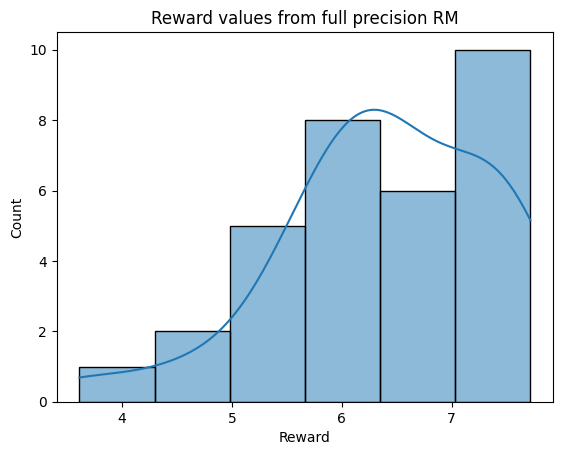

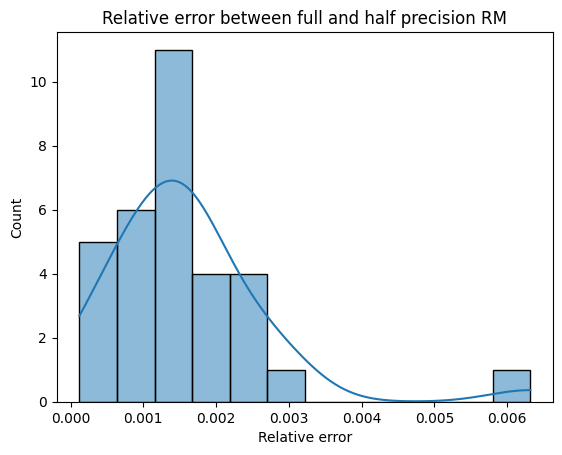

[5, 11, 17, 20, 23, 31, 15, 27, 2, 28, 13, 7, 12, 19, 4, 0, 18, 9, 16, 22, 25, 3, 10, 1, 29, 24, 14, 21, 30, 26, 8, 6]
[5, 11, 17, 20, 23, 31, 15, 27, 2, 28, 13, 7, 19, 12, 4, 0, 18, 9, 22, 16, 25, 3, 10, 1, 24, 29, 21, 14, 30, 26, 8, 6]
4
(6.256067276000977, 6.24609375)
(6.259022235870361, 6.2421875)
(6.623729228973389, 6.63671875)
(6.636852741241455, 6.625)
(7.390935897827148, 7.3984375)
(7.3940324783325195, 7.3828125)
(7.403314590454102, 7.41015625)
(7.4039154052734375, 7.40625)


In [43]:
sns.histplot(RM_full_score_0, kde=True, legend='Full RM', alpha=0.5)
plt.title('Reward values from full precision RM')
plt.xlabel('Reward')
# sns.histplot(RM_half_score_0, kde=True, legend='Half RM', alpha=0.5)
plt.show() 

rel_error = [abs(a-b)/a for a,b in zip(RM_full_score_0, RM_half_score_0)]

sns.histplot(rel_error, kde=True)
plt.title('Relative error between full and half precision RM')
plt.xlabel('Relative error')
plt.show()
#test if ranking the values gives the same result
indexes_full = sorted(range(len(RM_full_score_0)), key=lambda k: RM_full_score_0[k])
indexes_half = sorted(range(len(RM_half_score_0)), key=lambda k: RM_half_score_0[k])

print(indexes_full)
print(indexes_half)

#compute the number of permutations needed to get the same ranking
permutations = 0
similars = [] 
for i in range(len(indexes_full)):
    if indexes_full[i] != indexes_half[i]:
        permutations += 0.5
        similars.append((RM_full_score_0[indexes_full[i]], RM_half_score_0[indexes_full[i]]))

print(round(permutations))
for el in similars:
    print(el)

100%|██████████| 32/32 [18:56<00:00, 35.50s/it]


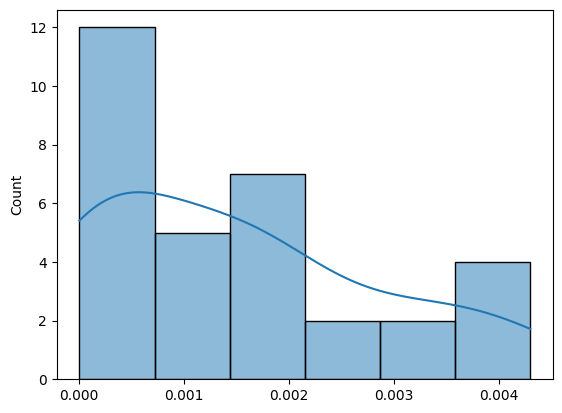

[5, 11, 17, 20, 23, 31, 15, 27, 2, 28, 13, 7, 12, 19, 4, 0, 18, 9, 16, 22, 25, 3, 10, 1, 29, 24, 14, 21, 30, 26, 8, 6]
[5, 11, 17, 20, 23, 31, 15, 27, 2, 28, 13, 7, 19, 12, 4, 0, 18, 9, 22, 16, 25, 3, 10, 1, 24, 29, 21, 14, 30, 26, 8, 6]


In [28]:
index = 1
prompts = ast.literal_eval(df.iloc[index]['N_response'])
RM_full_score_1 = []
RM_half_score_1 = ast.literal_eval(df.iloc[index]['RM_score'])
for el in tqdm(prompts):
    RM_full_score_1.append(get_reward_Ultra(el))

rel_error = [abs(a-b)/a for a,b in zip(RM_full_score_1, RM_half_score_1)]
sns.histplot(rel_error, kde=True)
plt.show()
#test if ranking the values gives the same result
indexes_full = sorted(range(len(RM_full_score_0)), key=lambda k: RM_full_score_0[k])
indexes_half = sorted(range(len(RM_half_score_0)), key=lambda k: RM_half_score_0[k])

print(indexes_full)
print(indexes_half)

#compute the number of permutations needed to get the same ranking
permutations = 0
for i in range(len(indexes_full)):
    if indexes_full[i] != indexes_half[i]:
        permutations += 0.5

In [36]:
index = 2
prompts = ast.literal_eval(df.iloc[index]['N_response'])
RM_full_score_2 = []
RM_half_score_2 = ast.literal_eval(df.iloc[index]['RM_score'])
for el in tqdm(prompts):
    RM_full_score_2.append(get_reward_Ultra(el))

rel_error = [abs((a-b)/a) for a,b in zip(RM_full_score_2, RM_half_score_2)]
sns.histplot(rel_error, kde=True)
plt.show()

 16%|█▌        | 5/32 [03:29<18:53, 42.00s/it]


KeyboardInterrupt: 